# Semi-supervised HMM and MM for Emotional Valence Modelling

A 7-state Hidden Markov Model and a 7-component Mixture Model both with heterogeneous emissions are trained with 233
patient sequences. Each of these sequences have some observations for the features of interest, there are no larger than
 30 days missing chunks and each sequence contains at least 1 emotional valence label.

In [1]:
# path settings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# set autoreload
%load_ext autoreload
%autoreload 2

## Load the Data

In [3]:
import pandas as pd

# --- define the columns corresponding to different variables of interest
gauss_columns = ['steps_total', 'distance', 'sleep', 'app_usage', 'home_cluster', 'clusters_count']
cat_columns = ['practiced_sport', 'valence']
data_columns = gauss_columns + cat_columns

# --- load preprocessed data
PATH = None
df_train = pd.read_csv(PATH)

print("There are {} patient sequences".format(df_train.id.nunique()))

There are 233 patient sequences


In [3]:
from src.utils.data_utils import compute_missing_data_stats, print_table

eB2_missing = ["eB2"] + compute_missing_data_stats(df_train, "id", gauss_columns+["practiced_sport"])
labels_missing = ["emotion"] + compute_missing_data_stats(df_train, "id", ["valence"])
stats = [eB2_missing, labels_missing]

print_table(stats, ["data", "#obs_seq", "min_len", "max_len", "#obs",
                    '#complete', '%complete', '#partial', '%partial', '#missing', '%missing'])

+---------+----------+---------+---------+-------+-----------+-----------+----------+----------+----------+----------+
|   data  | #obs_seq | min_len | max_len |  #obs | #complete | %complete | #partial | %partial | #missing | %missing |
+---------+----------+---------+---------+-------+-----------+-----------+----------+----------+----------+----------+
|   eB2   |   233    |    33   |   360   | 39694 |    6870   |   17.31   |  29715   |  74.86   |   3109   |   7.83   |
| emotion |   233    |    33   |   360   | 39694 |    4888   |   12.31   |    0     |   0.0    |  34806   |  87.69   |
+---------+----------+---------+---------+-------+-----------+-----------+----------+----------+----------+----------+


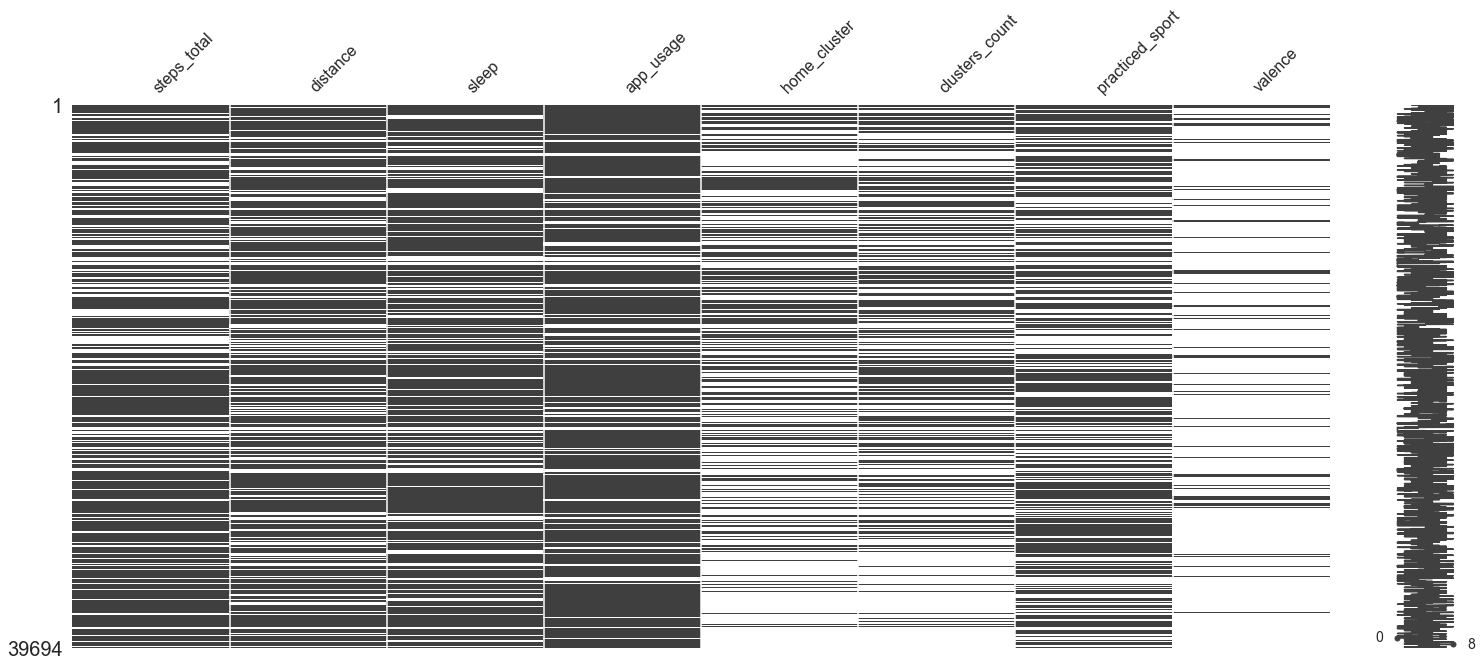

In [4]:
import missingno as msno

msno.matrix(df_train[data_columns]);

### Transform Dataframe to list of patient sequences

In [4]:
from src.utils.data_utils import df_to_list

# --- transform the columns of interest into list of observations
train_seq = df_to_list(df_train, data_columns)

## HMM Training

### 7-state HMM

#### Training

Initialisation 1
iter: 0, logL = -342696.419, delta = nan
iter: 10, logL = -131718.599, delta = 9635.962
iter: 20, logL = -48340.927, delta = 7794.758
iter: 30, logL = 17247.057, delta = 3791.791
iter: 40, logL = 29503.609, delta = 217.209
iter: 50, logL = 31124.666, delta = 247.253
iter: 60, logL = 32651.540, delta = 60.291
Converged -> iter: 66, logL = 32762.184
Initialisation 2
iter: 0, logL = -331778.177, delta = nan
iter: 10, logL = -120429.277, delta = 8391.123
iter: 20, logL = -45583.269, delta = 6897.962
iter: 30, logL = 12070.115, delta = 3706.303
iter: 40, logL = 24805.848, delta = 271.299
iter: 50, logL = 25859.207, delta = 59.815
iter: 60, logL = 26385.141, delta = 37.478
iter: 70, logL = 26665.663, delta = 27.728
Converged -> iter: 78, logL = 26881.925
Initialisation 3
iter: 0, logL = -327942.967, delta = nan
iter: 10, logL = -125437.913, delta = 7967.391
iter: 20, logL = -50488.285, delta = 7227.904
iter: 30, logL = 10783.027, delta = 4209.432
iter: 40, logL = 25436.710, 

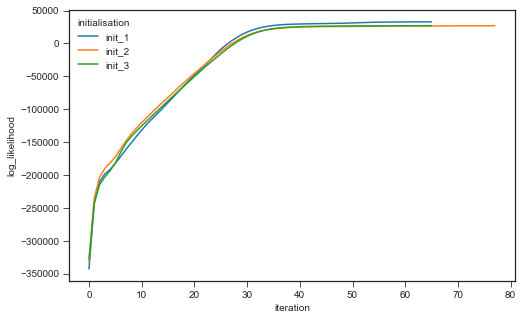

In [6]:
import numpy as np
import multiprocessing as mp
import src.utils.hmm_utils as hu
from src.models.hmm.HeterogeneousHMM import HeterogeneousHMM

# --- define folder path where to save results
folder_path = PATH

# --- initialise the parameters for the HMM
n_g_emissions = len(gauss_columns)  # no. of Gaussian features
n_d_emissions = len(cat_columns)    # no. of discrete
n_d_features = [2, 3]               # distinct possible symbols for each discrete emission
n_states = 7                        # no. of hidden states

# create the model
hmm = HeterogeneousHMM(
    n_states=n_states,
    n_g_emissions=n_g_emissions,
    n_d_emissions=n_d_emissions,
    n_d_features=n_d_features,
    nr_no_train_de=1,
    state_no_train_de=5,
    learn_rate=0.,
    params="stmce",
    init_params="stmce",
    init_type="kmeans",
    covariance_type="diagonal",
    verbose=True,
)

hmm.B = [0.5*np.ones((n_states, 2)),
          np.array([[0.33, 0.33, 0.34],
                    [0.33, 0.33, 0.34],
                    [1.0, 0., 0.],
                    [1.0, 0., 0.],
                    [0., 1.0, 0.],
                    [0., 0., 1.0],
                    [0., 0., 1.0]])]

# train the model to estimate the parameters
hmm, _ = hmm.train(
    train_seq, n_init=3, n_iter=100, thres=0.001, conv_iter=5,
    plot_log_likelihood=True, n_processes=mp.cpu_count(), print_every=10
)

# save the model
hu.save_model(hmm, folder_path+"hmm_7_daily.p")

#### Model parameters

In [7]:
# print model parameters
g_emissions = gauss_columns
d_emissions = [
    ["pract_sport = " + str(j) for j in [True, False]],
    ["valence = " + j for j in ["Negative", "Neutral", "Positive"]]
]
hu.pretty_print_hmm(hmm, hmm_type="Heterogeneous",
                    emissions=[g_emissions, d_emissions])

Priors
+------------+------------+------------+------------+------------+------------+------------+
|  State_0   |  State_1   |  State_2   |  State_3   |  State_4   |  State_5   |  State_6   |
+------------+------------+------------+------------+------------+------------+------------+
| P(0)=0.080 | P(1)=0.049 | P(2)=0.611 | P(3)=0.061 | P(4)=0.142 | P(5)=0.045 | P(6)=0.011 |
+------------+------------+------------+------------+------------+------------+------------+
Transitions
+---------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|    _    |   State_0    |   State_1    |   State_2    |   State_3    |   State_4    |   State_5    |   State_6    |
+---------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| State_0 | P(0|0)=0.463 | P(1|0)=0.090 | P(2|0)=0.125 | P(3|0)=0.103 | P(4|0)=0.061 | P(5|0)=0.073 | P(6|0)=0.085 |
| State_1 | P(0|1)=0.088 | P(1|1)=0.526 | P(2|1)

#### Bar plot of means

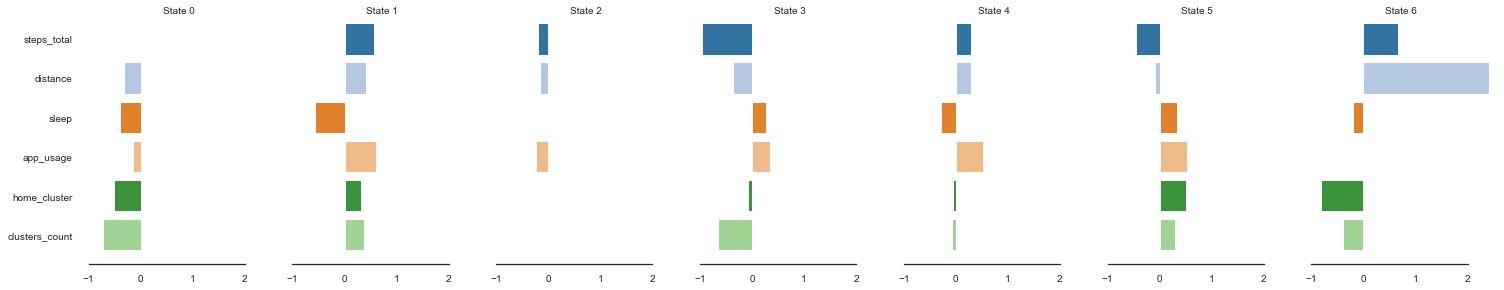

In [8]:
import seaborn as sns
sns.set_style("white")
sns.set_palette("tab20")

df_means = pd.DataFrame({
    "state" : [i for i in range(hmm.n_states) for j in range(hmm.n_g_emissions)],
    "features" : [ feat for i in range(hmm.n_states) for feat in gauss_columns],
    "means" : hmm.means.ravel()
})

g = sns.catplot(x="means", y="features",
                col="state", data=df_means, kind="bar",
                palette="tab20", height=4, aspect=.75)
(g.set_axis_labels("", "")
  .set_titles("State {col_name}")
  .despine(left=True, offset=10, trim=True));

#### Stationary state

In [9]:
hmm.get_stationary_distribution()

array([0.11993866, 0.12475193, 0.37860363, 0.09759652, 0.1076389 ,
       0.10560233, 0.06586802])

## MM Training

### 7-state MM
We transform the HMM into MM by fixing the transition probabilities to equal, and not adapting them during training.

#### Training

Initialisation 1
iter: 0, logL = -334866.501, delta = nan
iter: 10, logL = -152936.918, delta = 8908.475
iter: 20, logL = -77119.694, delta = 6959.716
iter: 30, logL = -14730.736, delta = 4657.147
iter: 40, logL = -1043.955, delta = 263.142
iter: 50, logL = -218.893, delta = 25.128
iter: 60, logL = -139.714, delta = 1.670
iter: 70, logL = -126.678, delta = 0.125
iter: 80, logL = -134.265, delta = -1.133
iter: 90, logL = -146.178, delta = -1.176
Maximum number of iterations reached. logL = -156.161


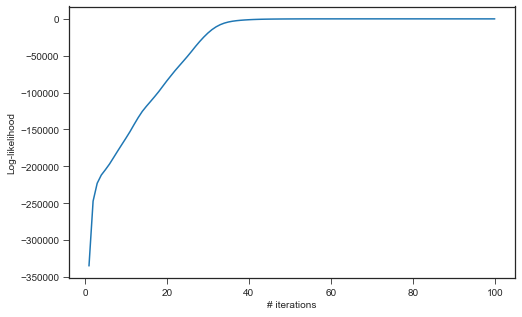

In [5]:
import numpy as np
import multiprocessing as mp
import src.utils.hmm_utils as hu
from src.models.hmm.HeterogeneousHMM import HeterogeneousHMM

# --- define folder path where to save results
folder_path = PATH

# --- initialise the parameters for the MM
n_g_emissions = len(gauss_columns)  # no. of Gaussian features
n_d_emissions = len(cat_columns)    # no. of discrete
n_d_features = [2, 3]               # distinct possible symbols for each discrete emission
n_states = 7                        # no. of hidden states

# create the model
mm = HeterogeneousHMM(
    n_states=n_states,
    n_g_emissions=n_g_emissions,
    n_d_emissions=n_d_emissions,
    n_d_features=n_d_features,
    nr_no_train_de=1,
    state_no_train_de=5,
    learn_rate=0.,
    params="smce",
    init_params="smce",
    init_type="kmeans",
    covariance_type="diagonal",
    verbose=True,
)

mm.A = np.full((n_states, n_states), 1.0/n_states)
mm.B = [0.5*np.ones((n_states, 2)),
          np.array([[0.33, 0.33, 0.34],
                    [0.33, 0.33, 0.34],
                    [1.0, 0., 0.],
                    [1.0, 0., 0.],
                    [0., 1.0, 0.],
                    [0., 0., 1.0],
                    [0., 0., 1.0]])]

# train the model to estimate the parameters
mm, _ = mm.train(
    train_seq, n_init=1, n_iter=100, thres=0.001, conv_iter=5,
    plot_log_likelihood=True, n_processes=mp.cpu_count(), print_every=10
)


# save the model
hu.save_model(mm, folder_path+"mm_7_daily.p")

#### Model parameters

In [6]:
# print model parameters
g_emissions = gauss_columns
d_emissions = [
    ["pract_sport = " + str(j) for j in [True, False]],
    ["valence = " + j for j in ["Negative", "Neutral", "Positive"]]
]
hu.pretty_print_hmm(mm, hmm_type="Heterogeneous",
                    emissions=[g_emissions, d_emissions])

Priors
+------------+------------+------------+------------+------------+------------+------------+
|  State_0   |  State_1   |  State_2   |  State_3   |  State_4   |  State_5   |  State_6   |
+------------+------------+------------+------------+------------+------------+------------+
| P(0)=0.093 | P(1)=0.090 | P(2)=0.541 | P(3)=0.047 | P(4)=0.171 | P(5)=0.042 | P(6)=0.014 |
+------------+------------+------------+------------+------------+------------+------------+
Transitions
+---------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|    _    |   State_0    |   State_1    |   State_2    |   State_3    |   State_4    |   State_5    |   State_6    |
+---------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| State_0 | P(0|0)=0.143 | P(1|0)=0.143 | P(2|0)=0.143 | P(3|0)=0.143 | P(4|0)=0.143 | P(5|0)=0.143 | P(6|0)=0.143 |
| State_1 | P(0|1)=0.143 | P(1|1)=0.143 | P(2|1)

#### Bar plot of means

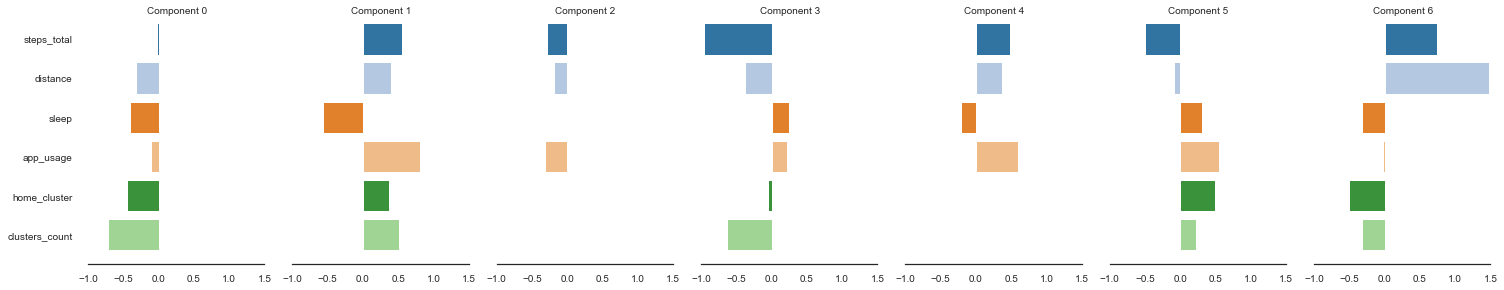

In [7]:
import seaborn as sns
sns.set_style("white")
sns.set_palette("tab20")

df_means = pd.DataFrame({
    "state" : [i for i in range(mm.n_states) for j in range(mm.n_g_emissions)],
    "features" : [ feat for i in range(mm.n_states) for feat in gauss_columns],
    "means" : mm.means.ravel()
})

g = sns.catplot(x="means", y="features",
                col="state", data=df_means, kind="bar",
                palette="tab20", height=4, aspect=.75)
(g.set_axis_labels("", "")
  .set_titles("Component {col_name}")
  .despine(left=True, offset=10, trim=True));

#### Stationary state

In [8]:
mm.get_stationary_distribution()


array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])